In [50]:
from scipy.integrate import simps
from scipy import integrate
import matplotlib.pyplot as plt
import numpy as np
np.seterr('ignore')

#constants
redshifts = np.linspace(0, 5, 100)
scale_factors = (1 + redshifts)**-1
scale_factor = lambda a: a
E_list = np.empty(100)
D_C_dist = np.empty(100)
D_c_dist = np.empty(100)
D_M_notzero_dist = np.empty(100)
D_M_zero_dist = np.empty(100)
D_m_dist = np.empty(100)
tComovingDist = np.empty(100)
coVolume_list = np.empty(100)
lum_dist = np.empty(100)
ang_dist = np.empty(100)
cosmic_age = np.empty(100)
lookback_time = np.empty(100)
h = 0.7
o_m = 1.0
o_l = 0.0
o_k = 0.0
D_H = 3000e6/h

# E(z) function
def E(o_m, o_l, o_k):
    for i in range(100):
        E_calc = np.sqrt(o_m*(1+redshifts[i])**3 + o_k*(1+redshifts[i])**2 + o_l)
        E_list[i] = E_calc
    return E_list

#E_a(o_m, o_l, o_k) = np.sqrt(o_m*(1+scale_factor)**-3 + o_k*(1+scale_factor)**-2 + o_l)

# line-of-sight comoving distance to be called in D_M function
def D_c(o_m, o_l, o_k):
    for i in range(1, 101):
        D_c_dist_calc = simps(E_list[:i]**-1, x = redshifts[:i])
        D_c_dist[i-1] = D_c_dist_calc
    return D_c_dist

# o_l != 0, transverse comoving distance
def D_M(o_m, o_l, o_k):
    if o_k != 0:
        for i in range(100):
            D_M_notzero_dist_calc = np.piecewise(o_k, [o_k > 0, o_k < 0], [np.sinh(np.sqrt(o_k)*D_c_dist[i])/np.sqrt(o_k), np.sinh(np.sqrt(abs(o_k))*D_c_dist[i])/np.sqrt(abs(o_k))])
            D_M_notzero_dist[i] = D_M_notzero_dist_calc
        return D_M_notzero_dist
    else:
        for i in range(100):
            D_M_zero_dist_calc = D_c_dist[i]
            D_M_zero_dist[i] = D_M_zero_dist_calc
        return D_M_zero_dist

# o_l = 0, transverse comoving distance
def D_m(o_m):
    for i in range(100):
        D_m_dist_calc = (2*(2-o_m*(1-redshifts[i])-(2-o_m)*np.sqrt(1+o_m*redshifts[i])))/(o_m**2*(1+redshifts[i]))
        D_m_dist[i] =  D_m_dist_calc
    return D_m_dist

# calls transverse comoving distance based on input o_l, o_k, o_m
def tComoving(o_m, o_l, o_k):
    if o_l == 0:
        D_m(o_m)
        for i in range(100):
            tComovingDist_calc = D_m_dist[i]
            tComovingDist[i] = tComovingDist_calc
        return tComovingDist
    else:
        E(o_m, o_l, o_k)
        D_c(o_m, o_l, o_k)
        D_M(o_m, o_l, o_k)
        if o_k != 0:
            for i in range(100):
                tComovingDist_calc = D_M_notzero_dist[i]
                tComovingDist[i] = tComovingDist_calc
            return tComovingDist
        else:
            for i in range(100):
                tComovingDist_calc = D_M_zero_dist[i]
                tComovingDist[i] = tComovingDist_calc
            return tComovingDist

# calls angular diameter distance
def aDiameterDist(o_m, o_l, o_k):
    tComoving(o_m, o_l, o_k)
    for i in range(100):
        ang_dist_calc = tComovingDist[i]/(1 + redshifts[i])
        ang_dist[i] = ang_dist_calc
    return ang_dist

# calls luminosity distance
def lumDist(o_m, o_l, o_k):
    tComoving(o_m, o_l, o_k)
    for i in range(100):
        lum_dist_calc = tComovingDist[i] * (1+ redshifts[i])
        lum_dist[i] = lum_dist_calc
    return lum_dist

# calls distance modulus
def dModulus(o_m, o_l, o_k):
    lumDist(o_m, o_l, o_k)
    return 5 * np.log10(lum_dist*D_H/10)

# calls comoving volume element
def coVolume(o_m, o_l, o_k):
    aDiameterDist(o_m, o_l, o_k)
    E(o_m, o_l, o_k)
    return ((1 + redshifts)**2 * ang_dist**2)/E_list

# calculation to be used in ageUniverse
def ageCalc(scale_factor, o_m, o_l, o_k):
    age_calc = lambda scale_factor: (scale_factor * np.sqrt(o_m*(scale_factor)**-3 + o_k*(scale_factor)**-2 + o_l))**-1
    return age_calc

# calculates age of universe
def ageUniverse(o_m, o_l, o_k):
    return integrate.quad(ageCalc(scale_factor, o_m, o_l, o_k), 0, 1)

# lookback time
def lookbackTime(o_m, o_l, o_k):
    E(o_m, o_l, o_k)
    for i in range(1, 101):
        lookback_time_calc = simps((E_list[:i] * (1 + redshifts[:i]))**-1, x = redshifts[:i])
        lookback_time[i-1] = lookback_time_calc
    return lookback_time

# cosmic age
def cosmicAge(o_m, o_l, o_k):
    E(o_m, o_l, o_k)
    lookbackTime(o_m, o_l, o_k)
    for i in range(100):
        cosmic_age_calc = ageUniverse(o_m, o_l, o_k)[0] - lookback_time[i]
        cosmic_age[i] = cosmic_age_calc
    return cosmic_age

# dimensionless intersection probability
def intProb(o_m, o_l, o_k):
    E(o_m, o_l, o_k)
    return (1 + redshifts)**2/E_list

(0.0, 3.0)

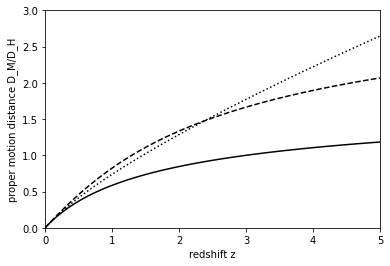

In [3]:
plt.plot(redshifts, tComoving(o_m, o_l, o_k), color = 'black', linestyle = 'solid')
plt.plot(redshifts, tComoving(0.05, 0, 0.95), color = 'black', linestyle = 'dotted')
plt.plot(redshifts, tComoving(0.2, 0.8, 0), color = 'black', linestyle = 'dashed')
plt.xlabel('redshift z')
plt.ylabel('proper motion distance D_M/D_H')
plt.xlim([0,5])
plt.ylim([0,3])

(0.0, 0.5)

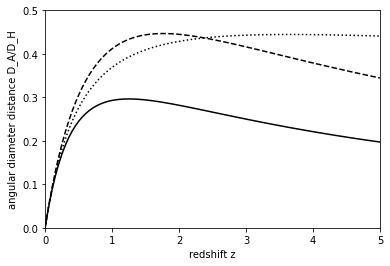

In [4]:
plt.plot(redshifts, aDiameterDist(1, 0, 0), color = 'black', linestyle = 'solid')
plt.plot(redshifts, aDiameterDist(0.05, 0, 0.95), color = 'black', linestyle = 'dotted')
plt.plot(redshifts, aDiameterDist(0.2, 0.8, 0), color = 'black', linestyle = 'dashed')
plt.xlabel('redshift z')
plt.ylabel('angular diameter distance D_A/D_H')
plt.xlim([0,5])
plt.ylim([0,0.5])

(0.0, 16.0)

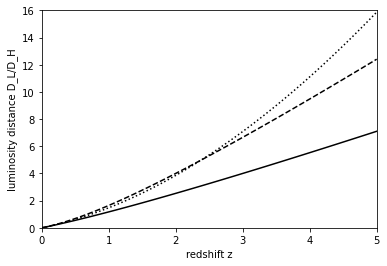

In [5]:
plt.plot(redshifts, lumDist(1, 0, 0), color = 'black', linestyle = 'solid')
plt.plot(redshifts, lumDist(0.05, 0, 0.95), color = 'black', linestyle = 'dotted')
plt.plot(redshifts, lumDist(0.2, 0.8, 0), color = 'black', linestyle = 'dashed')
plt.xlabel('redshift z')
plt.ylabel('luminosity distance D_L/D_H')
plt.xlim([0,5])
plt.ylim([0,16])

(40.0, 50.0)

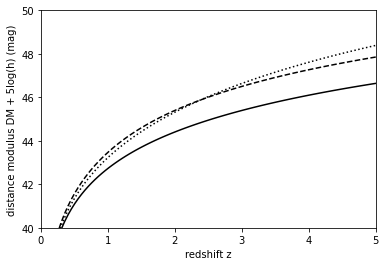

In [6]:
plt.plot(redshifts, dModulus(1, 0, 0) + 5 * np.log10(0.7), color = 'black', linestyle = 'solid')
plt.plot(redshifts, dModulus(0.05, 0, 0.95) + 5 * np.log10(0.7), color = 'black', linestyle = 'dotted')
plt.plot(redshifts, dModulus(0.2, 0.8, 0) + 5 * np.log10(0.7), color = 'black', linestyle = 'dashed')
plt.xlabel('redshift z')
plt.ylabel('distance modulus DM + 5log(h) (mag)')
plt.xlim([0,5])
plt.ylim([40,50])

(0.0, 1.1)

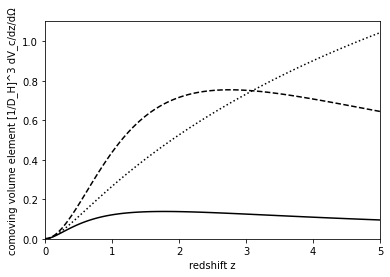

In [51]:
plt.plot(redshifts, coVolume(1, 0, 0), color = 'black', linestyle = 'solid')
plt.plot(redshifts, coVolume(0.05, 0, 0.95), color = 'black', linestyle = 'dotted')
plt.plot(redshifts, coVolume(0.2, 0.8, 0), color = 'black', linestyle = 'dashed')
plt.xlabel('redshift z')
plt.ylabel('comoving volume element [1/D_H]^3 dV_c/dz/dΩ')
plt.xlim([0,5])
plt.ylim([0,1.1])

(0.0, 1.2)

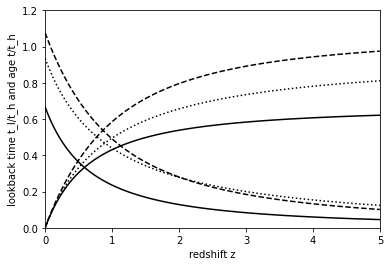

In [52]:
plt.plot(redshifts, cosmicAge(1, 0, 0), color = 'black', linestyle = 'solid')
plt.plot(redshifts, lookbackTime(1, 0, 0), color = 'black', linestyle = 'solid')
plt.plot(redshifts, cosmicAge(0.05, 0, 0.95), color = 'black', linestyle = 'dotted')
plt.plot(redshifts, lookbackTime(0.05, 0, 0.95), color = 'black', linestyle = 'dotted')
plt.plot(redshifts, cosmicAge(0.2, 0.8, 0), color = 'black', linestyle = 'dashed')
plt.plot(redshifts, lookbackTime(0.2, 0.8, 0), color = 'black', linestyle = 'dashed')
plt.xlabel('redshift z')
plt.ylabel('lookback time t_l/t_h and age t/t_h')
plt.xlim([0,5])
plt.ylim([0,1.2])

(0.0, 6.0)

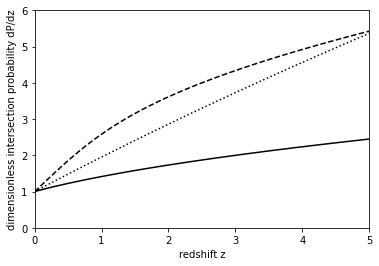

In [43]:
plt.plot(redshifts, intProb(1, 0, 0), color = 'black', linestyle = 'solid')
plt.plot(redshifts, intProb(0.05, 0, 0.95), color = 'black', linestyle = 'dotted')
plt.plot(redshifts, intProb(0.2, 0.8, 0), color = 'black', linestyle = 'dashed')
plt.xlabel('redshift z')
plt.ylabel('dimensionless intersection probability dP/dz')
plt.xlim([0,5])
plt.ylim([0,6])